# Chron.jl eruption/deposition age estimation

This Jupyter notebook demonstrates eruption (/deposition) age estimation component of `Chron.jl`, based on the approach of [Keller, Schoene, and Samperton (2018)](https://doi.org/10.7185/geochemlet.1826). For more information on `Chron.jl` and its other capabilities (largely, age-depth modelling), see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F)

<a href="https://mybinder.org/v2/gh/brenhinkeller/Chron.jl/main?filepath=examples%2FChron1.0DistOnly.ipynb" target="_blank"><img src="https://static.mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***

## Load required Julia packages

In [1]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add(PackageSpec(url="https://github.com/brenhinkeller/Chron.jl"))
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using Plots; gr(); default(fmt = :png)

***
## Enter sample information
First, let's enter some basic information about your samples. How many are there, what are the sample names (needs to be a valid filename, BTW), and what are the stratigraphic heights and uncertainties? Then, we'll enter the ages as .csv files.

In [2]:
nSamples = 5 # The number of samples you have data for
smpl = NewChronAgeData(nSamples)
smpl.Name      =  ("KJ08-157", "KJ04-75", "KJ09-66", "KJ04-72", "KJ04-70",)
smpl.Height   .=  [     -52.0,      44.0,      54.0,      82.0,      93.0,]
smpl.Height_sigma .= [    3.0,       1.0,       3.0,       3.0,       3.0,]
smpl.Age_Sidedness .= zeros(nSamples) # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "MyData/" # Where are the data files? Must match where you put the csv files below.
smpl.inputSigmaLevel = 2 # i.e., are the data files 1-sigma or 2-sigma. Integer.

smpl.Age_Unit = "Ma" # Unit of measurement for ages and errors in the data files
smpl.Height_Unit = "cm"; # Unit of measurement for Height and Height_sigma

Note that smpl.Height *must* increase with increasing stratigraphic height -- i.e., stratigraphically younger samples must be more positive. For this reason, it is convenient to represent depths below surface as negative numbers.
***
Now let's see what's in our current directory (we'll use `;` to activate Julia's command-line shell mode, followed by a unix command, in this case `ls`

In [3]:
;ls

Chron1.0Coupled.ipynb
Chron1.0Coupled.jl
Chron1.0DistOnly.ipynb
Chron1.0DistOnly.jl
Chron1.0Radiocarbon.ipynb
Chron1.0Radiocarbon.jl
Chron1.0StratOnly.ipynb
Chron1.0StratOnly.jl
DenverUPbExampleData
EruptionDepositionAgeDemonstration.ipynb
EruptionDepositionAgeDemonstration.jl
MyData
archive.tar.gz
ffsend


Equivalently, we can also run unix commands using the `run()` function

In [4]:
run(`ls`);

Chron1.0Coupled.ipynb
Chron1.0Coupled.jl
Chron1.0DistOnly.ipynb
Chron1.0DistOnly.jl
Chron1.0Radiocarbon.ipynb
Chron1.0Radiocarbon.jl
Chron1.0StratOnly.ipynb
Chron1.0StratOnly.jl
DenverUPbExampleData
EruptionDepositionAgeDemonstration.ipynb
EruptionDepositionAgeDemonstration.jl
MyData
archive.tar.gz
ffsend


Now that we know how to access the command line, let's make a new folder for our example data. This can be called whatever you want, just make sure it matches `smpl.Path` above

In [5]:
;mkdir -p MyData/

Now, let's make some files and paste in csv data for each one. For now, I'm pasting in example data from Clyde et al. (2016), [10.1016/j.epsl.2016.07.041](https://doi.org/10.1016/j.epsl.2016.07.041)

In [6]:
# You can just paste your data in here, in the following two-column format.
# The first column is age and the second column is two-sigma analytical uncertainty.
# You should generally exclude all systematic uncertainties here.
data = [
66.12 0.14
66.115 0.048
66.11 0.1
66.11 0.17
66.096 0.056
66.088 0.081
66.085 0.076
66.073 0.084
66.07 0.11
66.055 0.043
66.05 0.16
65.97 0.12
]

# Now, let's write this data to a file, delimited by commas (',')
# In this example the filename is KJ08-157.csv, in the folder called MyData
writedlm("MyData/KJ08-157.csv", data, ',')

In [7]:
data = [
66.24 0.25
66.232 0.046
66.112 0.085
66.09 0.1
66.04 0.18
66.03 0.12
66.016 0.08
66.003 0.038
65.982 0.071
65.98 0.19
65.977 0.042
65.975 0.066
65.971 0.082
65.963 0.074
65.92 0.12
65.916 0.088
]
writedlm("MyData/KJ04-75.csv",data,',')

In [8]:
data = [
66.13 0.15
66.066 0.052
65.999 0.045
65.989 0.057
65.98 0.11
65.961 0.057
65.957 0.091
65.951 0.066
65.95 0.11
65.929 0.059
]
writedlm("MyData/KJ09-66.csv",data,',')

In [9]:
data = [
66.11 0.2
66.003 0.063
66.003 0.058
65.98 0.06
65.976 0.089
65.973 0.084
65.97 0.15
65.963 0.055
65.959 0.049
65.94 0.18
65.928 0.066
65.92 0.057
65.91 0.14
]
writedlm("MyData/KJ04-72.csv",data,',')

In [10]:
data = [
66.22 0.27
66.06 0.11
65.933 0.066
65.918 0.087
65.92 0.34
65.916 0.067
65.91 0.18
65.892 0.09
65.89 0.063
65.89 0.15
65.88 0.2
65.812 0.069
65.76 0.15
]
writedlm("MyData/KJ04-70.csv",data,',')

Alternatively, you could download .csv files that you have posted somewhere online using the Julia `download()` function, or using the unix command `curl` throught the command-line interface

For each sample in `smpl.Name`, we must have a `.csv` file in `smpl.Path` which contains each individual mineral age and uncertainty.

***
## Configure and run eruption/deposition age model
To learn more about the eruption/deposition age estimation model, see also [Keller, Schoene, and Sameperton (2018)](https://doi.org/10.7185/geochemlet.1826) and the [BayeZirChron demo notebook](http://brenh.in/BayeZirChron). It is important to note that this model (like most if not all others) has no knowledge of open-system behaviour, so *e.g.*, Pb-loss will lead to erroneous results.

#### Boostrap relative pre-eruptive (or pre-depositional) mineral age distribution

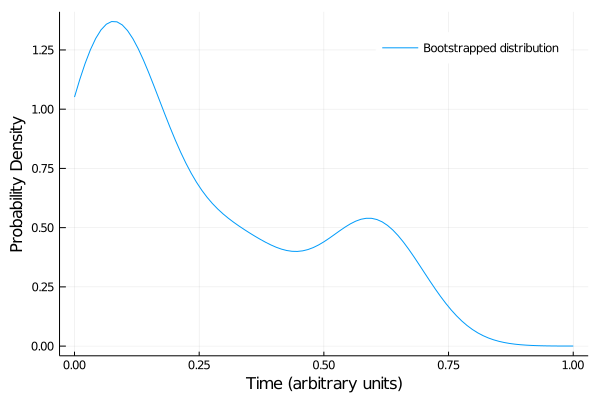

In [11]:
# Bootstrap a KDE of the pre-eruptive (or pre-deposition) zircon distribution
# shape from individual sample datafiles using a KDE of stacked sample data
BootstrappedDistribution = BootstrapCrystDistributionKDE(smpl)
h = plot(range(0,1,length=length(BootstrappedDistribution)), BootstrappedDistribution,
    label="Bootstrapped distribution", xlabel="Time (arbitrary units)", ylabel="Probability Density", 
    fg_color_legend=:white)
savefig(h, joinpath(smpl.Path,"BootstrappedDistribution.pdf"))
display(h)

#### Run eruption/deposition age model

In [12]:
# Number of steps to run in distribution MCMC
distSteps = 10^6
distBurnin = floor(Int,distSteps/100)

# Choose the form of the prior distribution to use
# Some pre-defined possiblilities include UniformDisribution,
# TriangularDistribution, and MeltsVolcanicZirconDistribution
# or you can define your own as with BootstrappedDistribution above
dist = BootstrappedDistribution

# Run MCMC to estimate saturation and eruption/deposition age distributions
smpl = tMinDistMetropolis(smpl,distSteps,distBurnin,dist)
results = vcat(["Sample" "Age" "2.5% CI" "97.5% CI" "sigma"], hcat(collect(smpl.Name),smpl.Age,smpl.Age_025CI,smpl.Age_975CI,smpl.Age_sigma))
writedlm(smpl.Path*"results.csv", results, ',');

Estimating eruption/deposition age distributions...
1: KJ08-157
2: KJ04-75
3: KJ09-66
4: KJ04-72
5: KJ04-70


In [13]:
# Let's see what that did
run(`ls $(smpl.Path)`); sleep(0.5)
results = readdlm(smpl.Path*"results.csv",',')

BootstrappedDistribution.pdf
KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_distribution.svg
KJ04-70_rankorder.pdf
KJ04-70_rankorder.svg
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_distribution.svg
KJ04-72_rankorder.pdf
KJ04-72_rankorder.svg
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_distribution.svg
KJ04-75_rankorder.pdf
KJ04-75_rankorder.svg
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_distribution.svg
KJ08-157_rankorder.pdf
KJ08-157_rankorder.svg
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_distribution.svg
KJ09-66_rankorder.pdf
KJ09-66_rankorder.svg
results.csv


6×5 Array{Any,2}:
 "Sample"      "Age"    "2.5% CI"    "97.5% CI"   "sigma"
 "KJ08-157"  66.0702  66.0339      66.0937       0.0151044
 "KJ04-75"   65.932   65.886       65.9712       0.0219181
 "KJ09-66"   65.9371  65.8925      65.9781       0.0214973
 "KJ04-72"   65.9551  65.9224      65.9767       0.0137792
 "KJ04-70"   65.8309  65.7543      65.8947       0.0363218

To see what one of these plots looks like, try pasting this into a markdown cell like the one below
```
<img src="MyData/KJ04-75_rankorder.svg" align="left" width="600"/>
```

<img src="MyData/KJ04-75_rankorder.svg" align="left" width="600"/>

For each sample, the eruption/deposition age distribution is inherently asymmetric, because of the one-sided relationship between mineral closure and eruption/deposition. For example (KJ04-70):

<img src="MyData/KJ04-70_distribution.svg" align="left" width="600"/>

(if no figure appears, double-click to enter this markdown cell and re-evaluate (`shift`-`enter`) after running the model above

***
## Getting your data out
As before, we can use the unix command `ls` to see all the files we have written. Actually getting them out of here may be harder though.

In [14]:
;ls MyData

BootstrappedDistribution.pdf
KJ04-70.csv
KJ04-70_distribution.pdf
KJ04-70_distribution.svg
KJ04-70_rankorder.pdf
KJ04-70_rankorder.svg
KJ04-72.csv
KJ04-72_distribution.pdf
KJ04-72_distribution.svg
KJ04-72_rankorder.pdf
KJ04-72_rankorder.svg
KJ04-75.csv
KJ04-75_distribution.pdf
KJ04-75_distribution.svg
KJ04-75_rankorder.pdf
KJ04-75_rankorder.svg
KJ08-157.csv
KJ08-157_distribution.pdf
KJ08-157_distribution.svg
KJ08-157_rankorder.pdf
KJ08-157_rankorder.svg
KJ09-66.csv
KJ09-66_distribution.pdf
KJ09-66_distribution.svg
KJ09-66_rankorder.pdf
KJ09-66_rankorder.svg
results.csv


We could use the trick we learned before to view the SVG files in markdown cells, which you should then be able to right click and download as real vector graphics. e.g. pasting something like
```
<img src="AgeDepthModel.svg" align="left" width="600"/>
```
in a markdown cell such as this one

Meanwhile, for the csv files we could try something like `; cat agedist.csv`, but agedist is probably too big to print. Let's try using ffsend instead, which should give you a download link. In fact, while we're at it, we might as well archive and zip the entire directory!

In [15]:
# Make gzipped tar archive of the the whole MyData directory
run(`tar -zcf archive.tar.gz ./MyData`);

In [16]:
# Download prebuilt ffsend linux binary
download("https://github.com/timvisee/ffsend/releases/download/v0.2.65/ffsend-v0.2.65-linux-x64-static", "ffsend")

# Make ffsend executable
run(`chmod +x ffsend`);

In [17]:
; ./ffsend upload archive.tar.gz

/bin/bash: ./ffsend: cannot execute binary file


You could alternatively use the ffsend command in this way to transfer individual files

Keep in mind that any changes you make to this online notebook won't persist after you close the tab (or after it times out) even if you save your changes! You have to either copy-paste or `file`>`Download as` a copy.
***


***
[![DOI](https://github.com/brenhinkeller/Chron.jl/raw/main/readme_figures/osf_io_TQX3F.svg?sanitize=true)](https://doi.org/10.17605/osf.io/TQX3F) 